# Python Project

## 1. Importing all libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.style.use('fivethirtyeight')
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import Ridge, Lasso, LinearRegression

## 2. Load Dataset

In [2]:
df = pd.read_csv(r"C:\Users\Abhishek Panda\Desktop\Data Science\Datasets\Updated_sales.csv")
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


## 3. Data Cleaning and Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30394 entries, 0 to 30393
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Order ID          30307 non-null  object
 1   Product           30307 non-null  object
 2   Quantity Ordered  30307 non-null  object
 3   Price Each        30307 non-null  object
 4   Order Date        30307 non-null  object
 5   Purchase Address  30307 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [4]:
df.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,30307,30307,30307,30307,30307,30307
unique,29019,20,9,24,23316,27854
top,Order ID,Lightning Charging Cable,1,14.95,Order Date,Purchase Address
freq,61,3556,27405,3556,61,61


In [5]:
df.isna().sum()

Order ID            87
Product             87
Quantity Ordered    87
Price Each          87
Order Date          87
Purchase Address    87
dtype: int64

###  1. Clean & Parse Dates

In [6]:
df = df[df['Order Date'].notna()]
df = df[df['Order Date'].astype(str).str.startswith(('0', '1'))]
df['Order Date'] = pd.to_datetime(df['Order Date'], format="%m/%d/%y %H:%M", errors='coerce')
df = df.dropna(subset=['Order Date'])

### 2. Extract DateTime Features

In [7]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Hour'] = df['Order Date'].dt.hour
df['Weekday'] = df['Order Date'].dt.weekday
df['Weekday Name'] = df['Order Date'].dt.day_name()
df.drop(['Order Date'], axis=1, inplace=True)


### 3. Convert Columns to Numeric

In [8]:
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')
df.dropna(subset=['Quantity Ordered', 'Price Each'], inplace=True)

### 4. Create Target Feature

In [9]:
df['Total Sales'] = df['Quantity Ordered'] * df['Price Each']

### 5. Drop Unnecessary Columns

In [10]:
df = df.drop(columns=['Order ID', 'Purchase Address'])
original_df = df.copy()

### 6. One-Hot Encoding

In [11]:
df = pd.get_dummies(df, drop_first=True)

## 4. EDA Visualisation


### 1. Monthly Sales

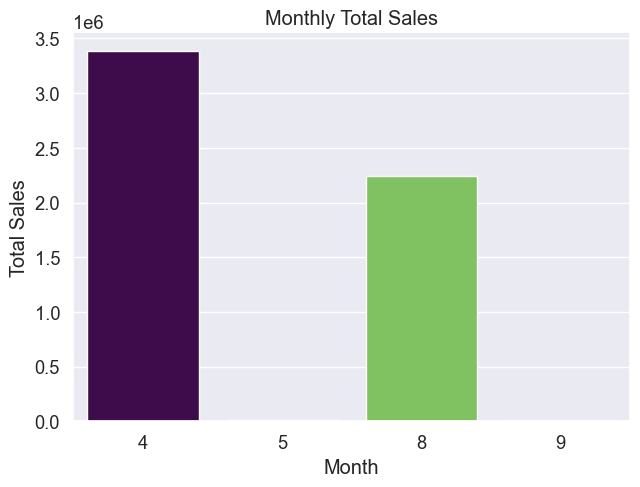

In [12]:
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2)
monthly_sales = original_df.groupby("Month")["Total Sales"].sum().reset_index()
sns.barplot(data=monthly_sales, x="Month", y="Total Sales",hue="Month", palette="viridis",legend=False)
plt.title("Monthly Total Sales")
plt.show()

### 2. Hourly Sales

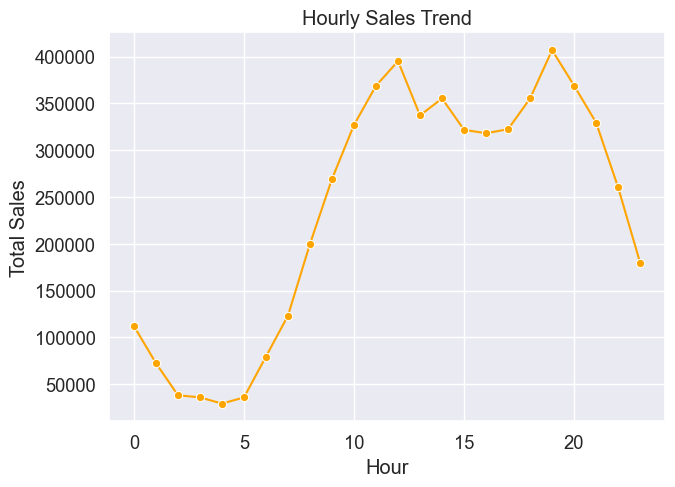

In [13]:
hourly_sales = original_df.groupby("Hour")["Total Sales"].sum().reset_index()
sns.lineplot(data=hourly_sales, x="Hour", y="Total Sales", marker="o", color="orange")
plt.title("Hourly Sales Trend")
plt.show()


### 3. Weekday Sales

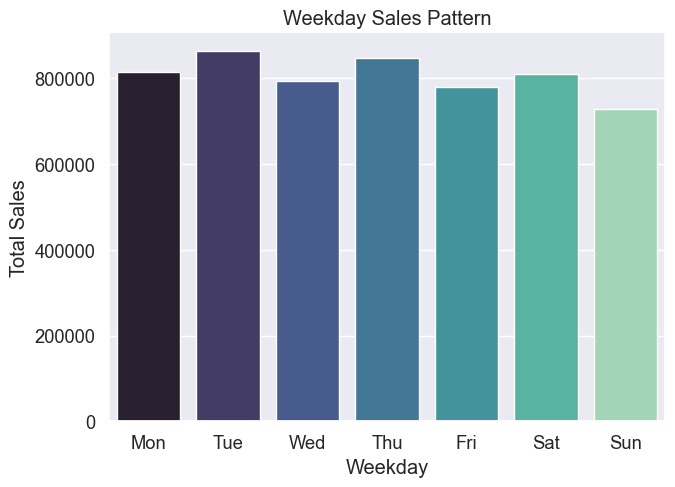

In [14]:
weekday_map = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_sales = original_df.groupby("Weekday")["Total Sales"].sum().reset_index()
weekday_sales["Weekday"] = weekday_sales["Weekday"].apply(lambda x: weekday_map[x])
sns.barplot(data=weekday_sales, x="Weekday", y="Total Sales", hue="Weekday",palette="mako", legend=False )
plt.title("Weekday Sales Pattern")
plt.show()

### 4. Top Products

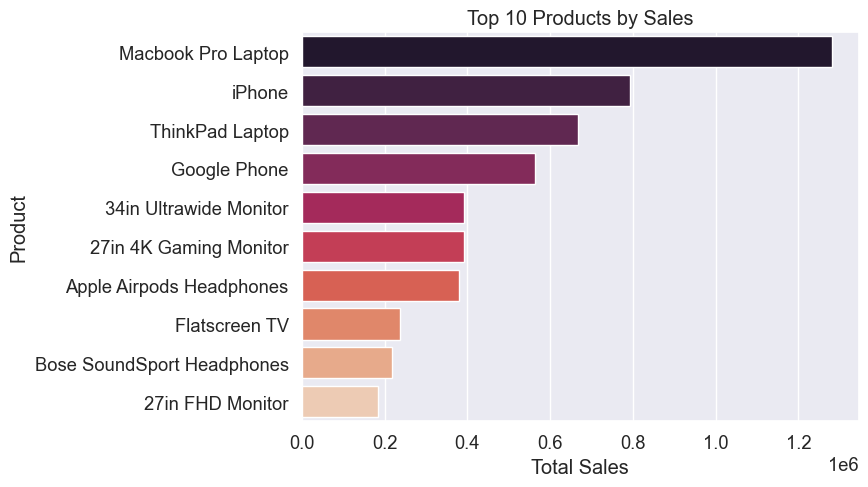

In [15]:
top_products = original_df.groupby("Product")["Total Sales"].sum().reset_index().sort_values(by="Total Sales", ascending=False).head(10)
sns.barplot(data=top_products, y="Product", x="Total Sales", hue="Product", palette="rocket",legend=False)
plt.title("Top 10 Products by Sales")
plt.show()

### 5. Price Distribution

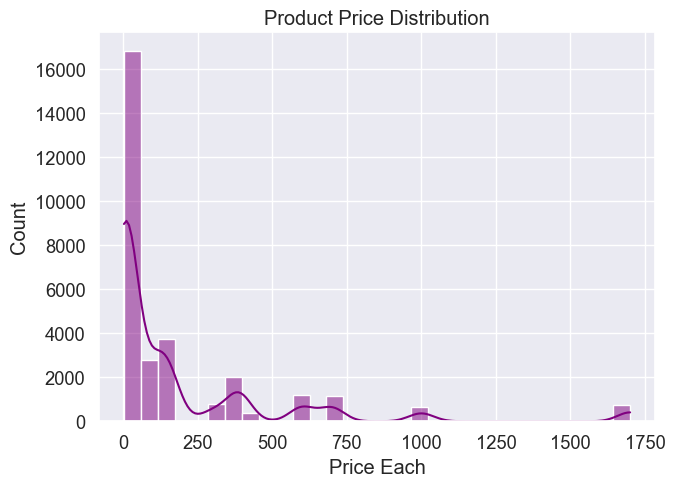

In [16]:
sns.histplot(data=original_df, x="Price Each", bins=30, kde=True, color='purple')
plt.title("Product Price Distribution")
plt.show()


### 6. Heatmap (Correlation Matrix)

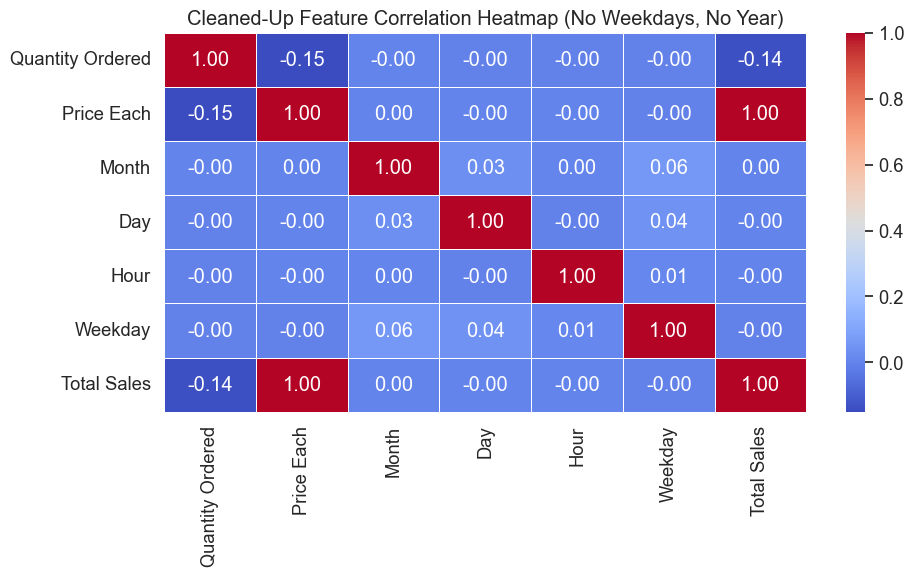

In [17]:
heatmap_df = df.copy()
product_cols = [col for col in heatmap_df.columns if col.startswith("Product_")]
weekday_cols = [col for col in heatmap_df.columns if col.startswith("Weekday Name_")]
heatmap_df = heatmap_df.drop(columns=product_cols + weekday_cols + ['Year'], errors='ignore')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cleaned-Up Feature Correlation Heatmap (No Weekdays, No Year)")
plt.tight_layout()
plt.show()


## 5. Feature Engineering & Model Training

## 1. Feature Extraction

In [18]:
X = original_df.drop(columns=['Total Sales', 'Price Each'])
y = original_df['Total Sales']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Training using Random Forest Regressor

In [19]:

model = RandomForestRegressor(n_estimators=30, max_depth=4, max_features=0.7, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 3. Evaluate Regression Model

In [20]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Performance Metrics:")
print(f" MAE: {mae:.2f},\n MSE: {mse:.2f},\n RMSE: {rmse:.2f},\n R²: {r2:.2%}")


Performance Metrics:
 MAE: 89.78,
 MSE: 13816.06,
 RMSE: 117.54,
 R²: 87.03%


## 6. Plot Actual vs Predicted

C:\Users\Abhishek Panda\AppData\Local\Temp\ipykernel_17224\3942600727.py:7: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Abhishek Panda\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


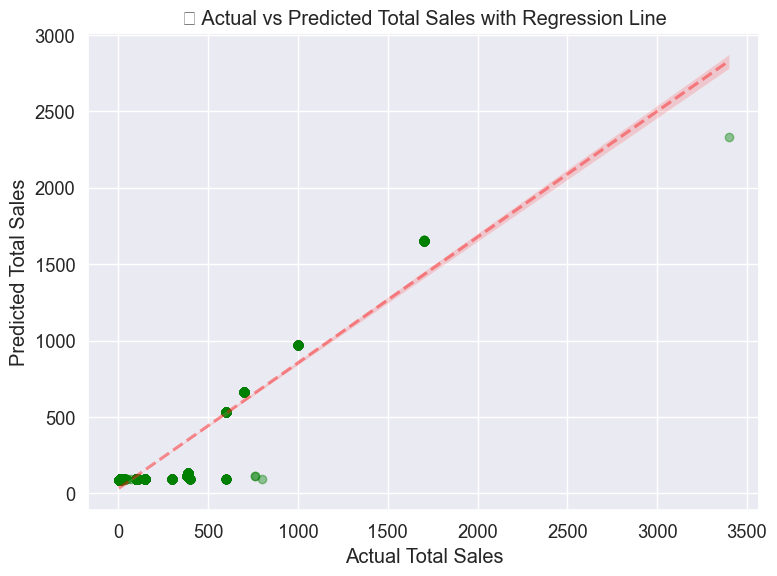

In [21]:
plt.figure(figsize=(8,6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.4, 'color': 'green'},
            line_kws={"color": "red", "linestyle": "--", "alpha": 0.4})
plt.xlabel("Actual Total Sales")
plt.ylabel("Predicted Total Sales")
plt.title("🎯 Actual vs Predicted Total Sales with Regression Line")
plt.tight_layout()
plt.show()


## 7. Before & After Scaling Visuals

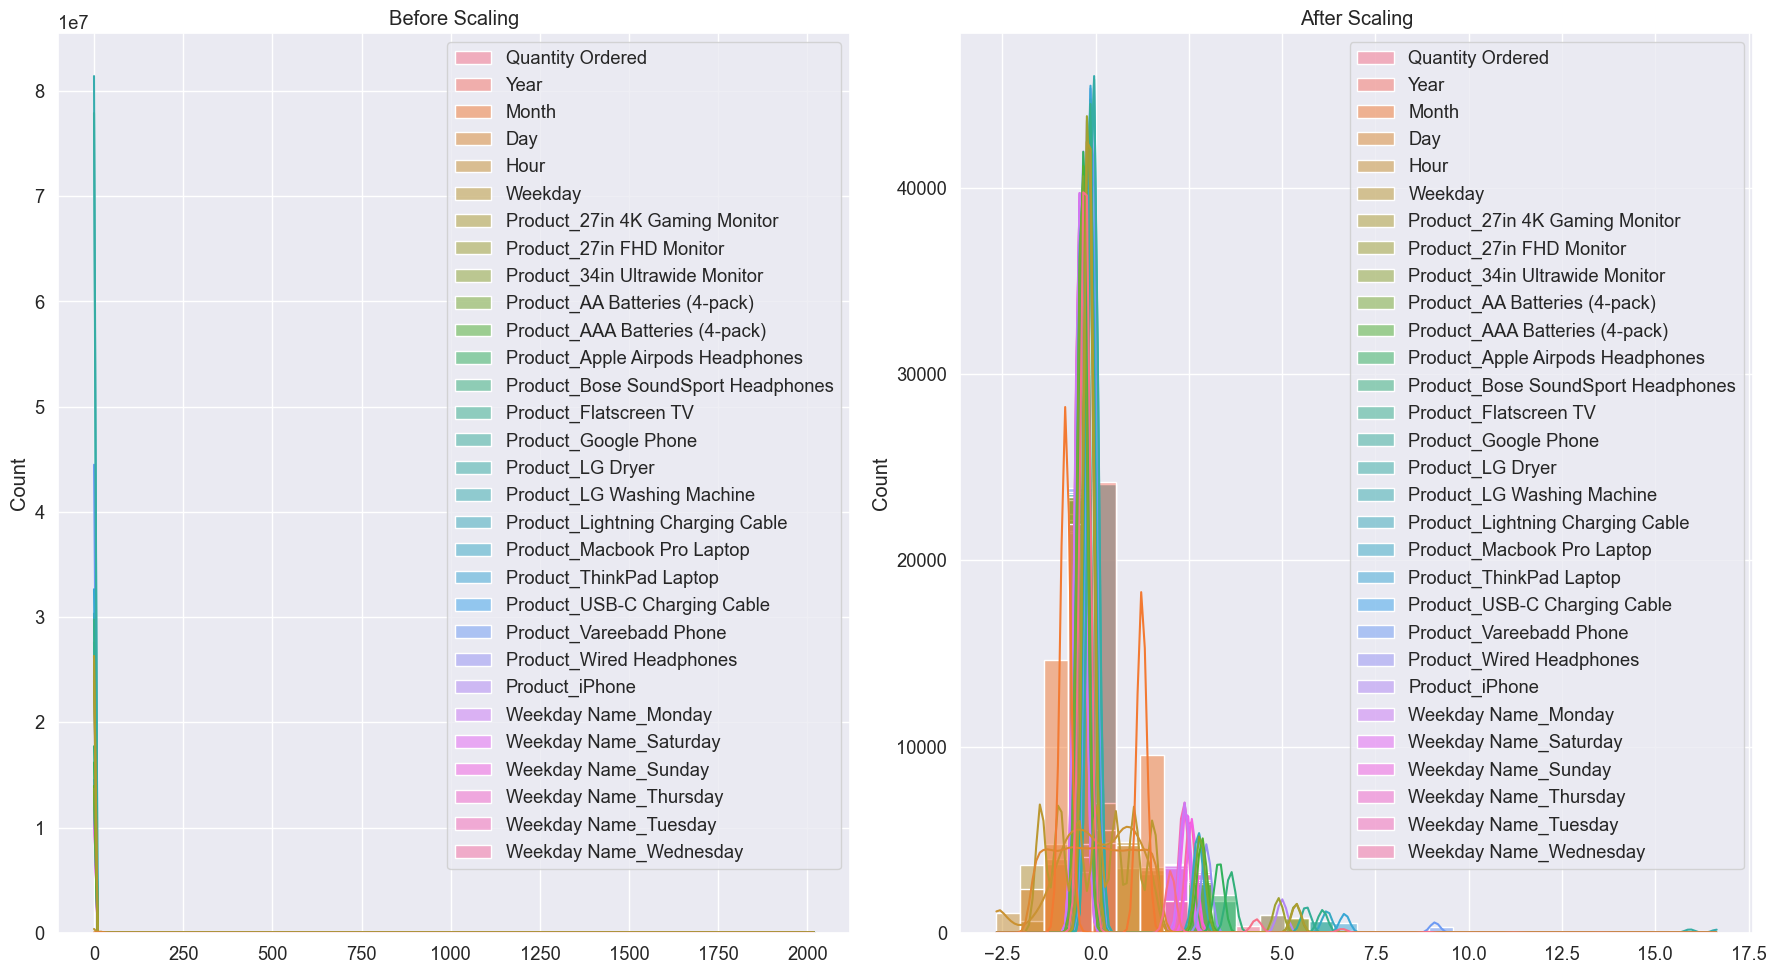

In [22]:
y_binary = original_df['Total Sales'].apply(lambda x: 0 if x < 1000 else 1)
X_binary = X.copy()

X_train, X_test, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.histplot(X_train, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Before Scaling")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

sns.histplot(X_train_scaled_df, bins=30, kde=True, ax=axes[1])
axes[1].set_title("After Scaling")
plt.tight_layout()
plt.show()


## 8. Train Classifier & Confusion Matrix

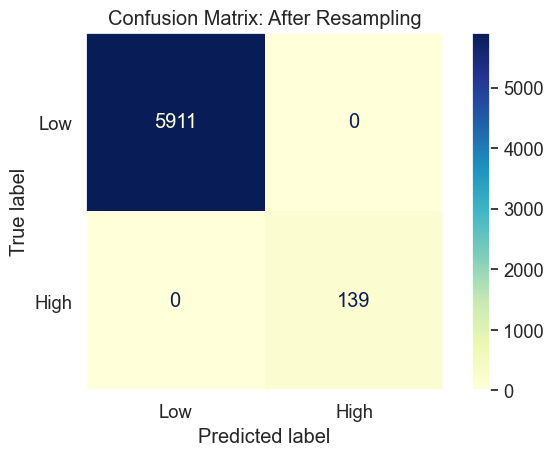

In [23]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train_bin)
y_pred_bin = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
disp.plot(cmap="YlGnBu")
plt.grid(False)
plt.title("Confusion Matrix: After Resampling")
plt.tight_layout()
plt.show()


## 9. Boxplot for Numerical Features

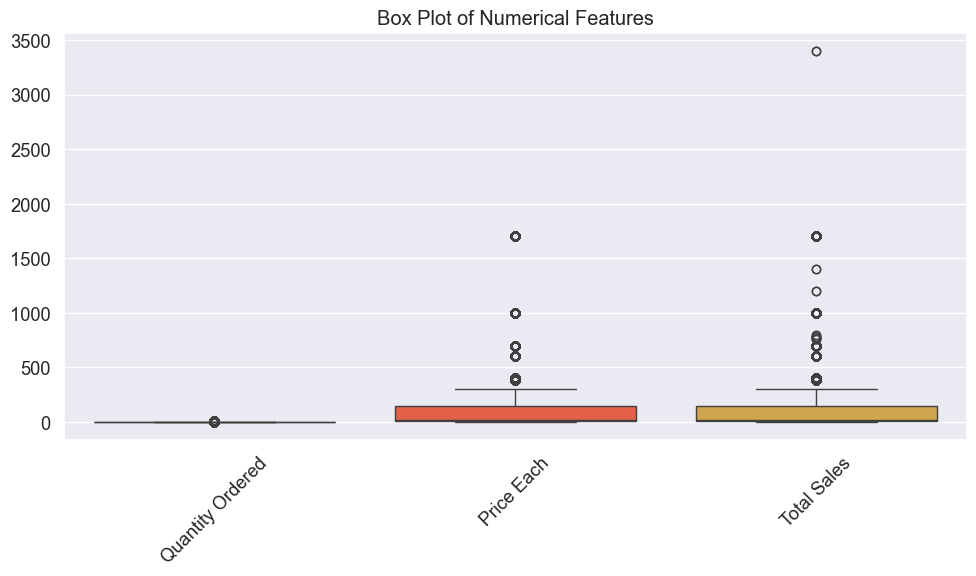

In [24]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_cols])
plt.title("Box Plot of Numerical Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 10. Ridge & Lasso Regression

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
lasso_preds = lasso.predict(X_test_scaled)

print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, ridge_preds)))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, lasso_preds)))


Ridge RMSE: 24.094162581082504
Lasso RMSE: 24.108887327253385


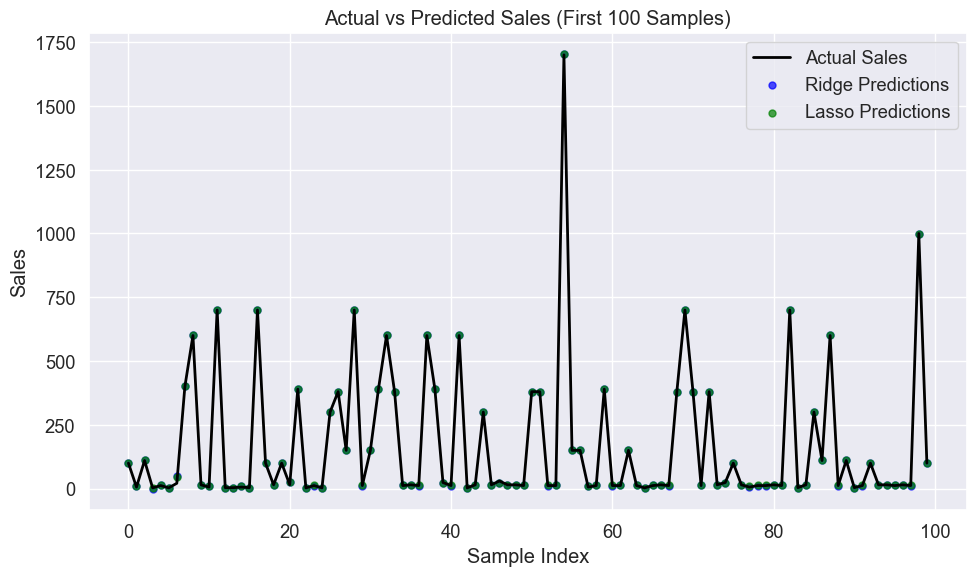

In [26]:
n = 100
actual = y_test.values[:n]
ridge_pred = ridge_preds[:n]
lasso_pred = lasso_preds[:n]

plt.figure(figsize=(10, 6))
plt.plot(actual, label="Actual Sales", color='black', linewidth=2)
plt.scatter(range(n), ridge_pred, label="Ridge Predictions", color='blue', s=25, alpha=0.7)
plt.scatter(range(n), lasso_pred, label="Lasso Predictions", color='green', s=25, alpha=0.7)

plt.title("Actual vs Predicted Sales (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
